In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import random


In [56]:
def ellipse_coord(coord):
    liste_coord = [float(i) for i in coord.split(" ")[:5]]
    major_axis = int(max(liste_coord[0], liste_coord[1]))
    minor_axis = int(min(liste_coord[0], liste_coord[1]))
    center_x, center_y = int(liste_coord[3]), int(liste_coord[4])
    
    return (major_axis, minor_axis, center_x, center_y)

In [57]:
def coord_rectangle_faces(ellipse_coords , img_shape):
    major_axis, minor_axis, center_x, center_y = ellipse_coords
    
    x_top_left = max(center_x - minor_axis, 0)  
    y_top_left = max(center_y - major_axis, 0)  
    x_right_bottom = min(center_x + minor_axis, img_shape[1])   
    y_right_bottom = min(center_y + major_axis, img_shape[0])  
    
    return x_top_left, y_top_left, x_right_bottom, y_right_bottom 

In [58]:
def coord_random_rectangle(face_box, image_shape):
    
    x1, y1, x2, y2 = face_box 
    
    xi1 = random.randint(0, image_shape[1] - (x2 - x1))
    yi1 = random.randint(0, image_shape[0] - (y2 - y1))
    
    
    xi2 = xi1 + (x2 - x1)
    yi2 = yi1 + (y2 - y1)
    
    return (xi1,  yi1, xi2, yi2)

In [59]:
def intersection_over_union(current_face_box, random_rectangle ):
    
    l1, t1, r1, b1 =  current_face_box
    l2, t2, r2, b2 =  random_rectangle
    
    
    li = max(l1, l2)
    ti = max(t1, t2)
    ri = min(r1, r2)
    bi = min(b1, b2)
    
    inter = max(ri-li+1, 0)*max(bi-ti+1,0)
    
    area1 = (r1-l1+1)*(b1-t1+1)
    area2 = (r2-l2+1)*(b2-t2+1)
    union =  area1 + area2 - inter 
    
    
    return inter/union

In [60]:
def  coord_rectan_back (current_face_box, faces_boxes_img, threshold_iou, random_rectangle):
    
   
    
    for face_box in faces_boxes_img:
 
        iou = intersection_over_union(face_box, random_rectangle)
        
        if iou > threshold_iou:  
            
            return True
        
    return False   
            
            
          

In [61]:
def build_folder_face (files_anno, main_folder):
    
    cpt = 1
    dict_annotation_faces = {}
    for file in files_anno:

        with open(file) as file_anno:
            
            while(True):

                image_path = file_anno.readline().strip("\n")
                
                if not image_path:
                    break
                
                img = cv.imread("./originalPics/"+image_path+".jpg")
               
                
                nbre_faces = file_anno.readline()         
                
                
                for _ in range(int(nbre_faces)):

                    ellipse_coords = ellipse_coord(file_anno.readline().strip("\n"))

                    x1, y1, x2, y2 = coord_rectangle_faces(ellipse_coords, img.shape)
                   
                    cropped_image = img[y1:y2, x1:x2]
                    
                    cv.imwrite("./"+main_folder+"/faces/"+str(cpt)+'.jpg', cropped_image)
    
                    cpt = cpt + 1
                    
                    dict_annotation_faces.setdefault(image_path, []).append((x1, y1, x2, y2))
                
            
                
   
            
    return dict_annotation_faces
                
                    
                


In [62]:
def build_folder_back(main_folder, dict_faces_box, threshold_iou):
    
    faces_number = len(glob.glob('./'+main_folder+'/faces/*.jpg'))
    cpt = 1
    
    while (cpt<faces_number):
        
        for image_path, faces_boxes_img in dict_faces_box.items():

            img = cv.imread("./originalPics/"+image_path+".jpg")
            
            img_copy = img.copy()

            for face_box in faces_boxes_img:
                
                random_rectan = coord_random_rectangle(face_box, img.shape)

                trials = 1

                while  coord_rectan_back(face_box, faces_boxes_img, threshold_iou, random_rectan) and trials<50 : 

                    random_rectan = coord_random_rectangle(face_box, img.shape)
                    trials+=1
    
                if trials<50:

                    xi1, yi1, xi2, yi2 = random_rectan
              
                    cropped_image = img_copy[yi1:yi2, xi1:xi2]
                    
                    cv.imwrite("./"+main_folder+"/background/"+str(cpt)+'.jpg', cropped_image)

                    cpt+=1

            
            if cpt > faces_number:
                break
             
                        
                            
                    
                        
                   

In [85]:

files_anno_training = glob.glob(".\FDDB-folds\FDDB-fold-0[1-8]-ellipseList.txt")
main_folder = 'training_folder'

dict_faces_boxes = build_folder_face(files_anno_training, main_folder)

build_folder_back(main_folder, dict_faces_boxes, threshold_iou = 0.05)





In [305]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "accuracy",
            factor=np.sqrt(0.1),
            mode = 'max',
            patience=10,
            min_lr=0.5e-6,
            verbose=1)

# this callback saves the best weights during the training
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model_acc.hdf5', monitor='val_accuracy',verbose=1, save_weights_only=False,save_best_only=True)

In [306]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator

In [323]:
height = 32
width = 32
img_window = (height, width, 3)
epochs = 100

train_ds = preprocessing.image_dataset_from_directory(
    directory = './training_folder/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    subset="training",
    class_names = ['background', "faces"],
    batch_size=256,
    image_size=(height, width),
    shuffle=True,
    seed = 0,
    
)

validation_ds = preprocessing.image_dataset_from_directory(
    directory = './training_folder/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical' ,    
    color_mode="rgb",
    class_names = ['background', "faces"],
    subset="validation",
    batch_size=512,
    image_size=(height, width),
    shuffle=True,
    seed = 0,
    
)



Found 8274 files belonging to 2 classes.
Using 6620 files for training.
Found 8274 files belonging to 2 classes.
Using 1654 files for validation.


In [102]:
# show dataset

#plt.figure(figsize=(14, 14))
#for images, labels in train_ds.take(2):
    
    #for i in range(nb):
        #ax = plt.subplot(nb/4, 4, i + 1)
        #plt.imshow(images[i].numpy().astype("uint8"))
        #print("i", i, "label", labels[i])
        #plt.title(labels[i])
        #plt.axis("off")

In [308]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(height, 
                                                              width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
#plt.figure(figsize=(10, 10))
#for images, _ in train_ds.take(1):
    #for i in range(9):
        #augmented_images = data_augmentation(images)
        #ax = plt.subplot(3, 3, i + 1)
        #plt.imshow(augmented_images[0].numpy().astype("uint8"))
        #plt.axis("off")

In [324]:

nbr_units = height*width*3

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Input(shape = img_window),
  layers.Flatten(),  
  layers.Dense(1024, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(512, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(2, activation = 'softmax')
])

model.summary()



Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling_5 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
input_10 (InputLayer)        multiple                  0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_28 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_29 (Dense)             (None, 2)               

In [325]:
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', "AUC"])
history = model.fit(train_ds, epochs= epochs, validation_data=validation_ds, callbacks=[checkpointer])


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 0.9615 - accuracy: 0.6751 - auc: 0.7242
Epoch 00001: val_accuracy did not improve from 0.94740
26/26 [==============================] - 7s 262ms/step - loss: 0.9615 - accuracy: 0.6751 - auc: 0.7242 - val_loss: 0.4209 - val_accuracy: 0.8222 - val_auc: 0.8933
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8276 - auc: 0.8997
Epoch 00002: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 245ms/step - loss: 0.4058 - accuracy: 0.8276 - auc: 0.8997 - val_loss: 0.3414 - val_accuracy: 0.8755 - val_auc: 0.9307
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8470 - auc: 0.9223
Epoch 00003: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 238ms/step - loss: 0.3551 - accuracy: 0.8470 - auc: 0.9223 - val_loss: 0.2706 - val_accuracy: 0.9015 - val_auc: 0.9582
Epoch 4/100
26/26 [

26/26 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9140 - auc: 0.9741
Epoch 00026: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 234ms/step - loss: 0.2066 - accuracy: 0.9140 - auc: 0.9741 - val_loss: 0.1832 - val_accuracy: 0.9299 - val_auc: 0.9793
Epoch 27/100
26/26 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.9139 - auc: 0.9727
Epoch 00027: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 244ms/step - loss: 0.2105 - accuracy: 0.9139 - auc: 0.9727 - val_loss: 0.2410 - val_accuracy: 0.9015 - val_auc: 0.9661
Epoch 28/100
26/26 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9218 - auc: 0.9748
Epoch 00028: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 246ms/step - loss: 0.2022 - accuracy: 0.9218 - auc: 0.9748 - val_loss: 0.1805 - val_accuracy: 0.9299 - val_auc: 0.9795
Epoch 29/100
26/26 [=========

26/26 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9228 - auc: 0.9792
Epoch 00051: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 245ms/step - loss: 0.1845 - accuracy: 0.9228 - auc: 0.9792 - val_loss: 0.1896 - val_accuracy: 0.9305 - val_auc: 0.9781
Epoch 52/100
26/26 [==============================] - ETA: 0s - loss: 0.1838 - accuracy: 0.9243 - auc: 0.9793
Epoch 00052: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 239ms/step - loss: 0.1838 - accuracy: 0.9243 - auc: 0.9793 - val_loss: 0.1766 - val_accuracy: 0.9353 - val_auc: 0.9809
Epoch 53/100
26/26 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9254 - auc: 0.9799
Epoch 00053: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 241ms/step - loss: 0.1814 - accuracy: 0.9254 - auc: 0.9799 - val_loss: 0.1635 - val_accuracy: 0.9341 - val_auc: 0.9833
Epoch 54/100
26/26 [=========

26/26 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9334 - auc: 0.9846
Epoch 00076: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 236ms/step - loss: 0.1589 - accuracy: 0.9334 - auc: 0.9846 - val_loss: 0.1618 - val_accuracy: 0.9383 - val_auc: 0.9841
Epoch 77/100
26/26 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9352 - auc: 0.9849
Epoch 00077: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 232ms/step - loss: 0.1570 - accuracy: 0.9352 - auc: 0.9849 - val_loss: 0.1651 - val_accuracy: 0.9389 - val_auc: 0.9831
Epoch 78/100
26/26 [==============================] - ETA: 0s - loss: 0.1662 - accuracy: 0.9293 - auc: 0.9832
Epoch 00078: val_accuracy did not improve from 0.94740
26/26 [==============================] - 6s 231ms/step - loss: 0.1662 - accuracy: 0.9293 - auc: 0.9832 - val_loss: 0.1562 - val_accuracy: 0.9389 - val_auc: 0.9846
Epoch 79/100
26/26 [=========

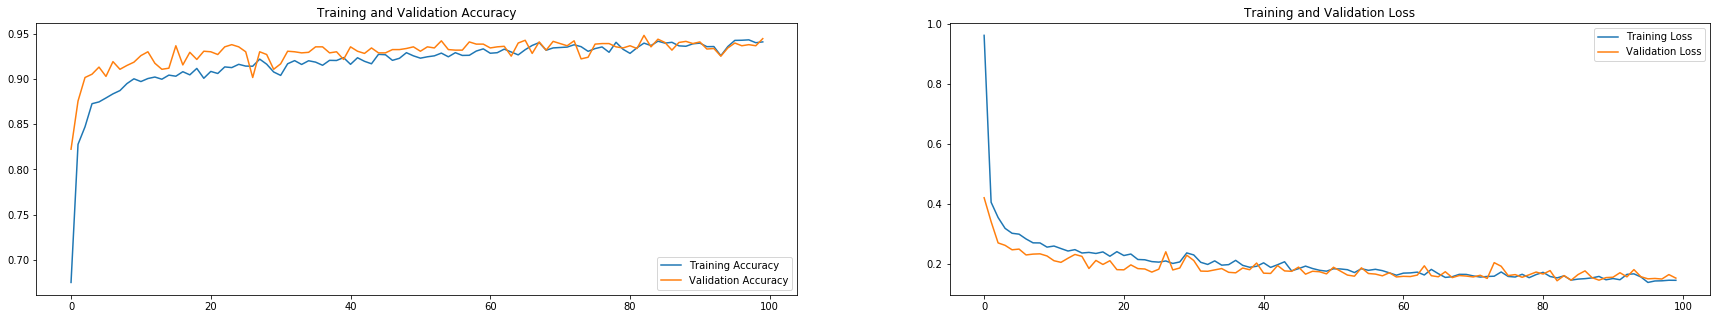

In [327]:
#vizualise
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 100
epochs_range = range(epochs)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [312]:
model.load_weights("model_acc.hdf5")

In [328]:
test_ds = preprocessing.image_dataset_from_directory(
    directory = './TESTSET/',
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    class_names = ['background', "faces"],
    batch_size=64,
    image_size=(height, width),
    shuffle=False,
)
    

Found 2070 files belonging to 2 classes.


In [329]:
score = model.evaluate(test_ds)

33/33 [==============================] - 2s 51ms/step - loss: 0.1720 - accuracy: 0.9382 - auc: 0.9838


In [330]:
files_img = glob.glob('./TESTSET/*/*')


dict_class = {'faces':1, 'background': 0}


for i,img_file in enumerate(files_img):
    img = keras.preprocessing.image.load_img( img_file, target_size=(height, width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
   
    score_eval = tf.nn.softmax(predictions[0])
    y_pred[i] = np.argmax(score_eval)
   
    y[i] = dict_class.get(img_file.split("\\")[-2])
    



In [331]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



print("accuracy is "+str(score[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(score[2]))

accuracy is 0.938164234161377
f1 is 0.9405989199803632
recall is 0.9256038647342996
precision is 0.9560878243512974
AUC is 0.983750581741333
